## Logistic regression with `pymc`

Logistic regression is one of the simplest statistical models &mdash; and like many things in life, simple here is often synonymous with extremely powerful. I'm interested in the Bayesian statistics approach to it, here using Python. 

Here, let's learn how to do this basic task with `pymc`, and notice if there are any gotchas worth mentioning.

### A note on `pymc4`
I started off this notebook by wanting to try out `pymc4` (backed by Tensorflow instead of the deprecated Theano backend).

### Task
I'll be using a [dataset from the `scikit-learn` mooc website](https://inria.github.io/scikit-learn-mooc/python_scripts/datasets_bike_rides.html?highlight=bike_rides). The dataset is composed of three sets of power meter measurements from the same rider over three rides.

1. We'll create an extra boolean column called `hr_zone_4` if the average heart rate hit the classic "Zone 4" training, commonly called lactate threshold.
2. Massage the rest of the data to create usable variables for regression
3. Perform the regression using `statsmodels` for benchmark
4. Perform the regression with `pymc4`!

Notice that our task is not very... interesting? We should just consider it a way to get working data and see if we can detect patterns.

In [1]:
import re

import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import corner

PLOT_STYLE = "darkgrid"
sns.set_theme(style=PLOT_STYLE)

# How many seconds per HH:MM:SS segment
SECONDS_MAP = {0: 1, 1: 60, 2: 60 * 60}
LOC = "https://github.com/INRIA/scikit-learn-mooc/raw/main/datasets/bike_rides.csv"


def clean_column_names(col: str) -> str:
    fixed = (
        col.strip()
        .lower()
        .replace(" ", "_")
        .replace("-", "_")
        .replace("(", "")
        .replace(")", "")
        .encode("ascii", "ignore")
        .decode("utf-8")
    )
    return fixed


def clean_timedelta_str(text: str) -> int:
    """Takes in dirty HH:MM:SS, returns seconds"""
    parts = text.replace(".", ":").split(":")

    # Times encoded with hunredths of a sec end with '00'
    if parts[-1] == "00":
        parts.pop()

    duration = 0
    for ix, part in enumerate(reversed(parts)):
        duration += SECONDS_MAP[ix] * int(part)
    return float(duration)


df = pd.read_csv(LOC, parse_dates=["timestamp"])
df.index = df["timestamp"]
df.columns = [clean_column_names(col) for col in df.columns]
#
# # We don't care about anything under a mile (?)
# df = df[df["distance"] >= 1]
#
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38254 entries, 2020-08-18 14:43:19 to 2020-09-13 14:56:01
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     38254 non-null  datetime64[ns]
 1   power         38254 non-null  float64       
 2   heart_rate    38254 non-null  float64       
 3   cadence       38254 non-null  float64       
 4   speed         38254 non-null  float64       
 5   acceleration  38254 non-null  float64       
 6   slope         38254 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 2.3 MB
None


,timestamp,power,heart_rate,cadence,speed,acceleration,slope
timestamp,,,,,,,
2020-08-18 14:43:19,2020-08-18 14:43:19,150.0,102.0,64.0,4.325,0.0880,-0.033870
2020-08-18 14:43:20,2020-08-18 14:43:20,161.0,103.0,64.0,4.336,0.0842,-0.033571
2020-08-18 14:43:21,2020-08-18 14:43:21,163.0,105.0,66.0,4.409,0.0234,-0.033223
2020-08-18 14:43:22,2020-08-18 14:43:22,156.0,106.0,66.0,4.445,0.0016,-0.032908
2020-08-18 14:43:23,2020-08-18 14:43:23,148.0,106.0,67.0,4.441,0.1144,0.000000


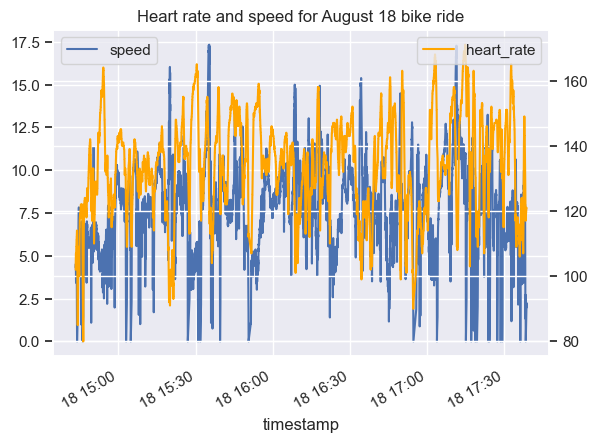

In [2]:
ax = fig, ax = plt.subplots()
df[df.index < "2020-08-19"]["speed"].plot(ax=ax, legend=True)
ax2 = ax.twinx()
df[df.index < "2020-08-19"]["heart_rate"].plot(
    ax=ax2,
    color="orange",
    legend=True,
    title="Heart rate and speed for August 18 bike ride",
)
ax.legend(loc="upper left")
ax2.legend(loc="upper right")
ax;

We can see that we have a lot of rides with power output near or at zero. This is explained by coasting: when the rider is e.g. cornering or flying downhill. Let's examine this.

<AxesSubplot: ylabel='Frequency'>

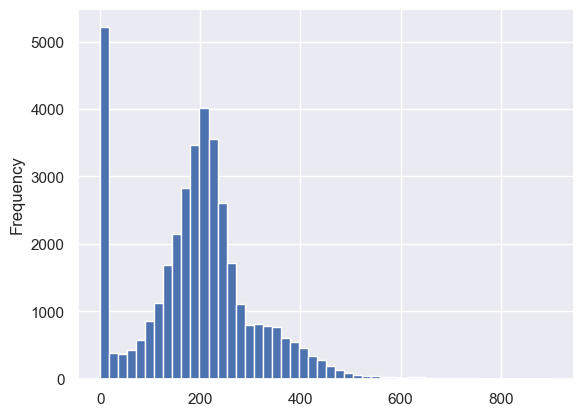

In [3]:
df["power"].plot.hist(bins=50)

That's a lot of rows – I'm guessing from rides/riders without a cycle with a power meter installed. For our purposes let's just discard these rows, we'll still have plenty left.

In [4]:
df = df[df["power"] > 10]

<AxesSubplot: ylabel='Frequency'>

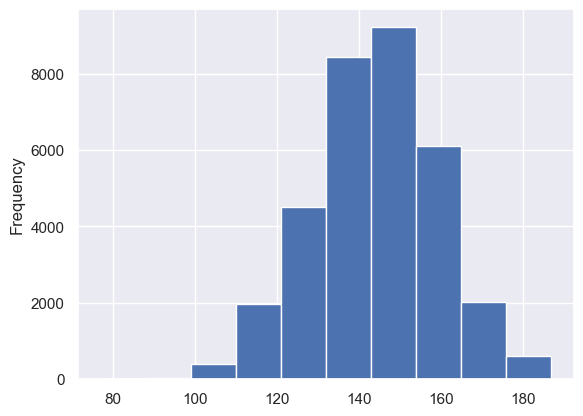

In [5]:
df["heart_rate"].plot.hist()

<AxesSubplot: >

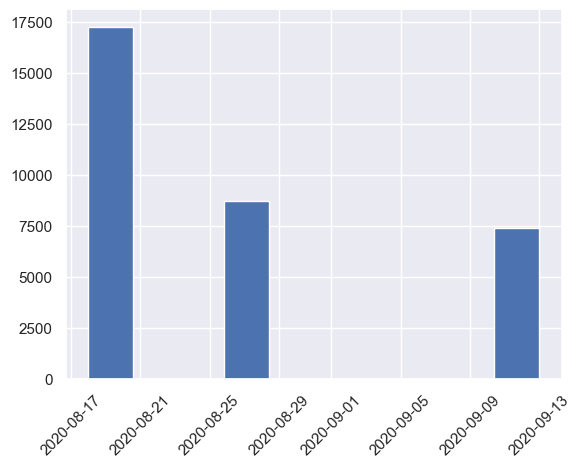

In [6]:
df["timestamp"].dt.date.hist(xrot=45)

<AxesSubplot: ylabel='Frequency'>

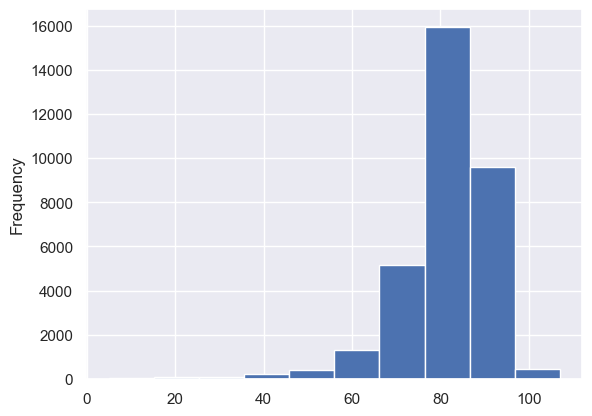

In [7]:
df["cadence"].plot.hist()

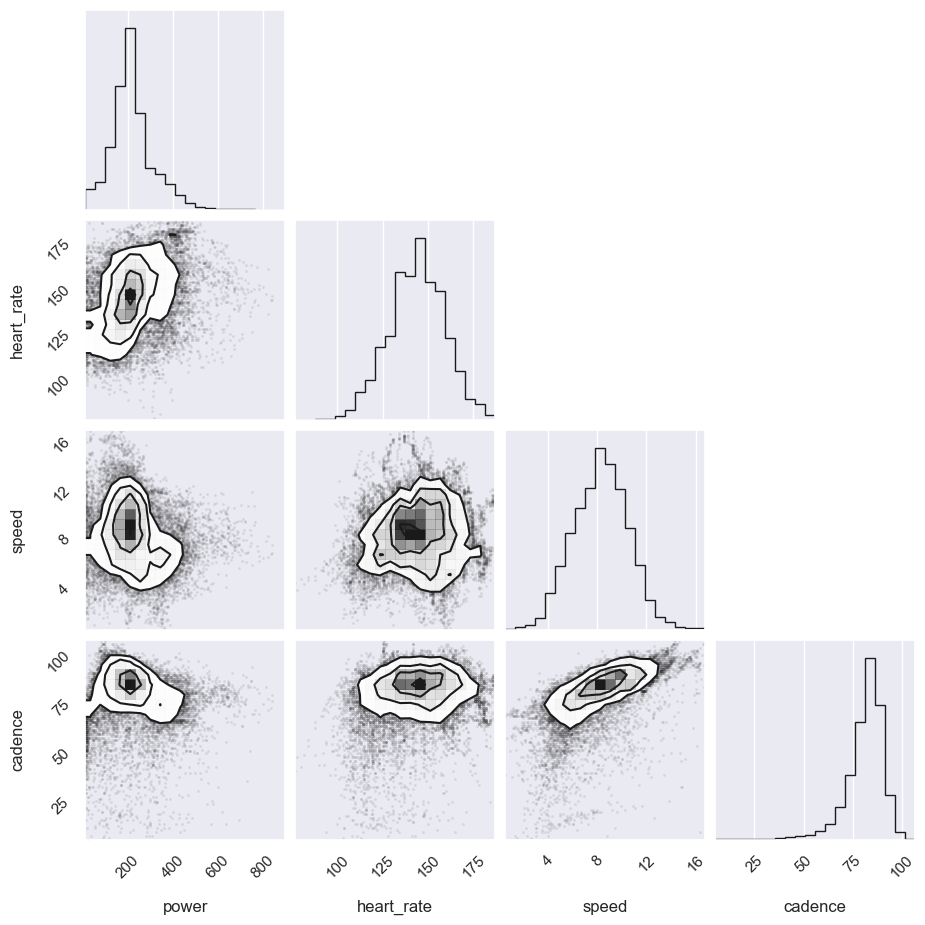

In [10]:
corner.corner(df[["power", "heart_rate", "speed", "cadence"]]);

### Target variable

Our target variable will be whether that training session was in Heart Rate Zone. This is otherwise known as Lactate Threshold training. It hurts.

>HEART RATE ZONE 4: 80–90% OF HRMAX
>If you train at this intensity, you’ll improve your speed endurance. Your body will get better at using carbohydrates for energy and you’ll be able to withstand higher levels of lactic acid in your blood for longer.

Given that:

>Most commonly, maximum heart rate is calculated by subtracting your age from 220. For a 30-year-old person, for example: `220 – 30 = 190`.

and that we also see have a maximum HR of 190 in the data, so this seems like a plausible number. 

In [9]:
TARGET_VARIABLE = "zone_4"
MAX_HR = df["max_hr"].max()
LOWER_BOUND = 0.8 * MAX_HR
UPPER_BOUND = 0.9 * MAX_HR

df[TARGET_VARIABLE] = (df["avg_hr"] >= LOWER_BOUND) & (df["avg_hr"] <= UPPER_BOUND)
df[TARGET_VARIABLE] = df[TARGET_VARIABLE].astype(int)
df[TARGET_VARIABLE].value_counts()

KeyError: 'max_hr'

In [ ]:
dummies = pd.get_dummies(df, columns=["activity_type"], prefix="activity")
for col in ["date"]:
    del dummies[col]

dummies.corrwith(dummies[TARGET_VARIABLE])

In [ ]:
def correlation_plot(df):
    f = plt.figure(figsize=(19, 15))
    plt.matshow(df.corr(), fignum=f.number)
    plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=90)
    plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Correlation Matrix", fontsize=16)
    plt.show()


correlation_plot(dummies)

So let's forget about:

* `date`, as it's useless
* `avg_hr`, as using heart rate is data leak,
* `max_hr`, as using heart rate is data leak,
* `elev_loss`, as it's almost perfectly correlated with `elev_gain`,
* `normalized_power_np`, as I don't know what it is,
* `training_stress_score`, as I don't know what it is,
* `max_avg_power_20_min` and `max_power`, as they're greatly correlated with `power`,
* `activity_type`, as it's irrelevant to our intended outcome, and
* `calories`, as it's almost perfectly correlated with distance.

## Benchmark – Logistic regression with `statsmodels`

In [ ]:
from patsy import dmatrices

equation = "zone_4 ~ distance + time + avg_speed + max_speed + elev_gain + avg_bike_cadence + power"
y, X = dmatrices(equation, df, return_type="dataframe")

logistic_ss = sm.Logit(y, X)
results_ss = logistic_ss.fit()
results_ss.summary()

In [ ]:
sns.lmplot(x="power", y="zone_4", data=df, logistic=True)

>**🛫 Digression**

So interestingly, this rider has a tendency to pedal faster (i.e. increase her bike cadence) when she's doing Zone 4 workouts!

One almost sure-fire way to increase your efficiency on a bike is to train to increase your [cadence in the sweet spot of 90-100 rpm in order to save your energy](https://blog.wahoofitness.com/cycling-cadence-what-is-it-how-to-improve-yours/#:~:text=So%20what's%20the%20ideal%20cadence,from%2080%20to%20100%20RPMs.).

## Logistic regression with `pymc3`

In [ ]:
with pm.Model() as model:
    pm_model = model
    pm.glm.GLM.from_formula(equation, df.dropna(), family=pm.glm.families.Binomial())
    trace = pm.sample(random_seed=123, init="adapt_diag")

In [ ]:
pm.plot_trace(trace)

In [ ]:
az.from_pymc3(trace)

As as aside, I have a fairly modern laptop, and I still can't believe how this trace took over 30 seconds to generate. 